# cRBMS for classification
Generative models such as our cRBM model a probability distribution of the data.\\
We want to use a model that was trained on DHSs for classifcation in order to compare it to other methods.

In [1]:
# some always important inputs
import sys
import os
import random
import time
import numpy as np
import cPickle
#import PIL
from corebio.seq import Alphabet
from weblogolib import LogoData, LogoFormat, LogoOptions, classic, png_print_formatter, png_formatter
from cStringIO import StringIO
np.set_printoptions(precision=2, suppress=True)

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

testset_size = 400

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


Couldn't import dot_parser, loading of dot files will not be possible.


# Get the data

In [2]:
# read in the data
seqReader = seqReader = dataRead.SeqReader()
data_sc = np.array([i for i in seqReader.readSequencesFromFile('../data/stemcells.fa')])
data_fib = np.array([i for i in seqReader.readSequencesFromFile('../data/fibroblast.fa')])
data_fib = data_fib[:data_sc.shape[0]]
print data_sc.shape
print data_fib.shape

skip sequence containing N
(3997, 1, 4, 200)
(3997, 1, 4, 200)


In [3]:
#fib2 = seqReader.readSequencesFromFile('../data/fibroblast.fa')
#fib2_per = np.random.permutation(len(fib2))
#data_fib = np.array([fib2[i] for i in fib2_per[:4000]])

train_sc = data_sc[testset_size:]
train_fib = data_fib[testset_size:]

test_sc = data_sc[:testset_size]
test_fib = data_fib[:testset_size]

In [4]:
data_all = np.concatenate((data_sc, data_fib), axis=0)
testset_all = np.concatenate((test_sc, test_fib), axis=0)
trainset_all = np.concatenate((train_sc, train_fib), axis=0)

# Markov Models
A first order *Markov Model* can be used to determine some sort of lower bound of our cRBM model.
But for that, we first have to implement this.
In a Markov Model, we simply count occurences of "words". The transition probabilities are then the occurences of the words divided by the total amount of words.

In [5]:
class MarkovModel:

    def __init__(self, alphabet=['A', 'C', 'G', 'T']):
        self.TPM = None
        self.alphabet = alphabet
        self.background = np.zeros(len(alphabet))
        self.scores = None

    def trainModel(self, data):
        self.TPM = np.zeros((len(self.alphabet), len(self.alphabet)))
        for sequence in range(data.shape[0]):
            for position in range(data.shape[3]-1):
                from_pos = np.argmax(data[sequence, 0, :, position])
                to_pos = np.argmax(data[sequence, 0, :, position+1])
                self.TPM[from_pos, to_pos] += 1
        
        self.TPM /= (data.shape[0] * (data.shape[3]-1))
        self.background = np.mean(data, axis=(0, 1, 3))
        print self.background
        print self.TPM
        
    def setTPM(self, TPM):
        self.TPM = TPM
    
    def evaluateSequences(self, testset):
        log_probs = np.log(self.TPM)
        print log_probs
        scores = np.zeros(testset.shape[0])
        for sequence in range(testset.shape[0]):
            for position in range(testset.shape[3]-1):
                from_pos = np.argmax(testset[sequence, 0, :, position])
                to_pos = np.argmax(testset[sequence, 0, :, position+1])
                scores[sequence] += log_probs[from_pos, to_pos]
        self.scores = scores
        return scores

In [6]:
mm_sc = MarkovModel()
mm_sc.trainModel(train_sc)

[ 0.27  0.23  0.23  0.27]
[[ 0.08  0.05  0.08  0.06]
 [ 0.07  0.06  0.01  0.08]
 [ 0.06  0.06  0.07  0.05]
 [ 0.05  0.06  0.07  0.09]]


In [7]:
mm_fib = MarkovModel()
mm_fib.trainModel(train_fib)

[ 0.31  0.19  0.19  0.31]
[[ 0.1   0.05  0.07  0.08]
 [ 0.07  0.04  0.01  0.07]
 [ 0.06  0.04  0.04  0.05]
 [ 0.07  0.06  0.07  0.11]]


In [8]:
# evaluate sequences
scores_sc = mm_sc.evaluateSequences(testset_all)
scores_fib = mm_fib.evaluateSequences(testset_all)
scores_mm = scores_sc - scores_fib

[[-2.47 -3.06 -2.58 -2.78]
 [-2.59 -2.75 -4.21 -2.59]
 [-2.8  -2.87 -2.73 -3.04]
 [-3.   -2.8  -2.59 -2.46]]
[[-2.26 -3.   -2.66 -2.51]
 [-2.6  -3.18 -4.81 -2.67]
 [-2.83 -3.13 -3.17 -3.  ]
 [-2.7  -2.83 -2.59 -2.25]]


# SVM classifier
The SVM should be some sort of upper bound for our classification problem.
Let's try how well it does...

In [9]:
# convert data to kmer representation

print "Convert DNA sequences to k-mer representation..."
start = time.time()
km_train = dataRead.computeKmerCounts(trainset_all, 5)
km_test = dataRead.computeKmerCounts(testset_all, 5)

labels = np.concatenate( (np.ones(train_sc.shape[0]), np.ones(train_fib.shape[0])*(-1)), axis=0 )

print "Done in " + str(time.time()-start) + " seconds!"
print km_train.shape
print km_test.shape
print labels.shape

Convert DNA sequences to k-mer representation...
Done in 12.1294090748 seconds!
(7194, 1024)
(800, 1024)
(7194,)


In [10]:
from sklearn import svm

# train the SVM classifier
clf = svm.SVC(probability=True)
clf.fit(km_train, labels)
print "Training complete"

Training complete


In [11]:
scores_svm = clf.predict_proba(km_test)
print scores_svm.shape
print scores_svm

(800, 2)
[[ 0.    1.  ]
 [ 0.    1.  ]
 [ 0.11  0.89]
 ..., 
 [ 0.94  0.06]
 [ 1.    0.  ]
 [ 1.    0.  ]]


In [12]:
svm2 = svm.SVC()
svm2.fit(km_train, labels)
scores = svm2.decision_function(km_test)

In [13]:
from sklearn.metrics import roc_auc_score
test_labels = np.concatenate( (np.ones(testset_size), np.zeros(testset_size)), axis=0 )

print roc_auc_score(test_labels, scores)
print roc_auc_score(test_labels, scores_svm[:,1])

0.98139375
0.9814


# Use the model's free energy for classification
The real probabilites are hard to compute because the partition function is needed for that.
Since we can't estimate it easily, we take the free energy of the data instead.

In [14]:
import theano
import theano.tensor as T
batchSize = 100

def getFreeEnergyFunction (model, data):
    D = T.tensor4('data')
    dataS = theano.shared(value=data, borrow=True, name='givenData')
    index = T.lscalar()
    energy = model.freeEnergyForData(D)
    return theano.function([index], energy, allow_input_downcast=True,
                           givens={D: dataS[index*batchSize:(index+1)*batchSize]},
                           name='freeDataEnergy'
                          )

def applyFreeEnergyFunction(model, data):
    fun = getFreeEnergyFunction(model, data)
    iterations = data.shape[0] / batchSize
    score = 0.
    for batchIdx in xrange(iterations):
        score += fun(batchIdx).sum()
    score /= iterations
    return score

def getFreeEnergyPoints(model, data):
    fun = getFreeEnergyFunction(model, data)
    iterations = data.shape[0] / batchSize
    M = np.zeros(data.shape[0])
    for batchIdx in xrange(iterations):
        #print "Setting from idx " + str(batchIdx*batchSize) + " to " + str((batchIdx+1)*batchSize)
        M[batchIdx*batchSize:(batchIdx+1)*batchSize] = fun(batchIdx)
    M[(batchIdx+1)*batchSize:] = fun(batchIdx+1)
    return M

In [15]:
# read in the models
print os.getcwd()
date_string_1 = 'Training_stemcells_sparsity_5'
modelDir_1 = '../../training/sparsity_constraints/' + date_string_1
stemcell_model = CRBM(file_name = modelDir_1 + '/model.pkl')

date_string_2 = 'Training_fibroblast_sparsity_5'
modelDir_2 = '../../training/sparsity_constraints/' + date_string_2
fibroblast_model = CRBM(file_name = modelDir_2 + '/model.pkl')

/home/sasse/ConvolutionalRBM/notebooks


In [16]:
print stemcell_model.motifs.get_value()[0]
print fibroblast_model.motifs.get_value()[0]

[[[-1.61 -0.3  -0.6  -0.39  0.65  0.85  0.73 -0.83 -0.64]
  [ 0.16  0.2  -0.89  0.01  0.69 -0.26  0.34 -0.64  0.21]
  [ 1.35  1.41  0.78 -0.2  -0.21 -1.26 -1.8   0.79  0.82]
  [ 0.57 -0.32 -0.01 -0.58 -0.37 -0.49  0.66  0.28  0.35]]]
[[[-0.08 -0.09 -1.07  0.32 -0.87 -0.12 -0.38 -0.82 -0.43]
  [ 0.53  0.67  0.1  -0.59 -0.55 -2.64  0.44  0.54  0.52]
  [ 0.43  0.45  0.21 -0.4  -1.27 -1.09 -0.01 -0.25 -0.75]
  [-0.12  0.79 -0.5   0.19 -2.11 -0.56  0.53 -0.92  0.09]]]


In [17]:
print "Model for stemcell data"
print "=============================="
stemcell_model.printHyperParams()
print "Model for fibroblast data"
print "=============================="
fibroblast_model.printHyperParams()

Model for stemcell data
{'batch_size': 20,
 'cd_k': 5,
 'cd_method': 'pcd',
 'doublestranded': False,
 'epochs': 300,
 'learning_rate': 0.5,
 'momentum': 0.9,
 'motif_length': 9,
 'number_of_motifs': 100,
 'pooling_factor': 4,
 'rho': 0.0011111111111111111,
 'sparsity': 5,
 'verbose': False}
Model for fibroblast data
{'batch_size': 20,
 'cd_k': 5,
 'cd_method': 'pcd',
 'doublestranded': False,
 'epochs': 300,
 'learning_rate': 0.5,
 'momentum': 0.9,
 'motif_length': 9,
 'number_of_motifs': 100,
 'pooling_factor': 4,
 'rho': 0.0011111111111111111,
 'sparsity': 5,
 'verbose': False}


In [18]:
print "Mean Free Energy for Model 1 (dataset 1 and 2)"
print applyFreeEnergyFunction(stemcell_model, test_sc)
print applyFreeEnergyFunction(stemcell_model, test_fib)
print "Mean Free Energy for Model 2 (dataset 1 and 2)"
print applyFreeEnergyFunction(fibroblast_model, test_sc)
print applyFreeEnergyFunction(fibroblast_model, test_fib)

Mean Free Energy for Model 1 (dataset 1 and 2)
-29.8209949993
-26.1872714497
Mean Free Energy for Model 2 (dataset 1 and 2)
-18.128793187
-23.6065108646


In [19]:
P11 = getFreeEnergyPoints(stemcell_model, test_sc)
print "ESC data on ESC model done"
P12 = getFreeEnergyPoints(stemcell_model, test_fib)
print "IMR90 data on ESC model done"
P21 = getFreeEnergyPoints(fibroblast_model, test_sc)
print "ESC data on IMR90 model done"
P22 = getFreeEnergyPoints(fibroblast_model, test_fib)
print "IMR90 data on IMR90 model done"

ESC data on ESC model done
IMR90 data on ESC model done
ESC data on IMR90 model done
IMR90 data on IMR90 model done


In [20]:
print P11.shape
print P12.shape

(400,)
(400,)


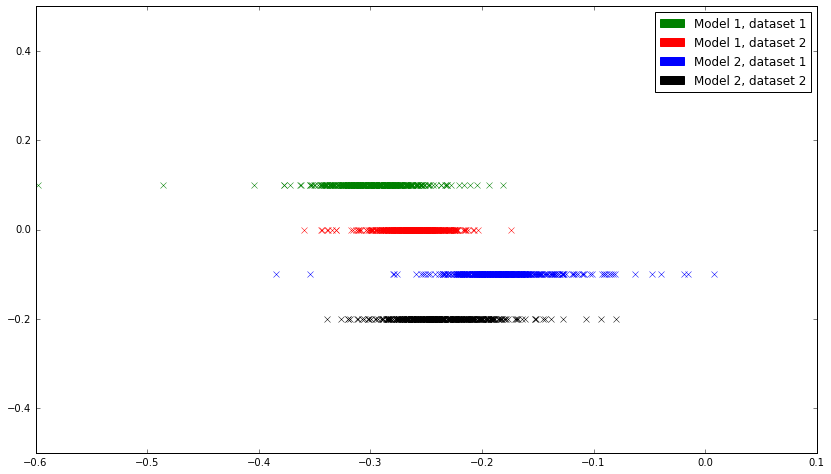

In [21]:
%matplotlib inline
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(14,8))
plt.plot(P11, np.zeros_like(P11)+0.1, 'x', color='green')
plt.plot(P12, np.zeros_like(P12), 'x', color='red')
plt.plot(P21, np.zeros_like(P21)-0.1, 'x', color='blue')
plt.plot(P22, np.zeros_like(P22)-0.2, 'x', color='black')
plt.ylim((-.5, .5))
green_patch = mpatches.Patch(color='green', label='Model 1, dataset 1')
red_patch = mpatches.Patch(color='red', label='Model 1, dataset 2')
blue_patch = mpatches.Patch(color='blue', label='Model 2, dataset 1')
black_patch = mpatches.Patch(color='black', label='Model 2, dataset 2')
plt.legend(handles=[green_patch, red_patch, blue_patch, black_patch])
plt.show()
fig.savefig('discriminative_power.png', dpi=400)

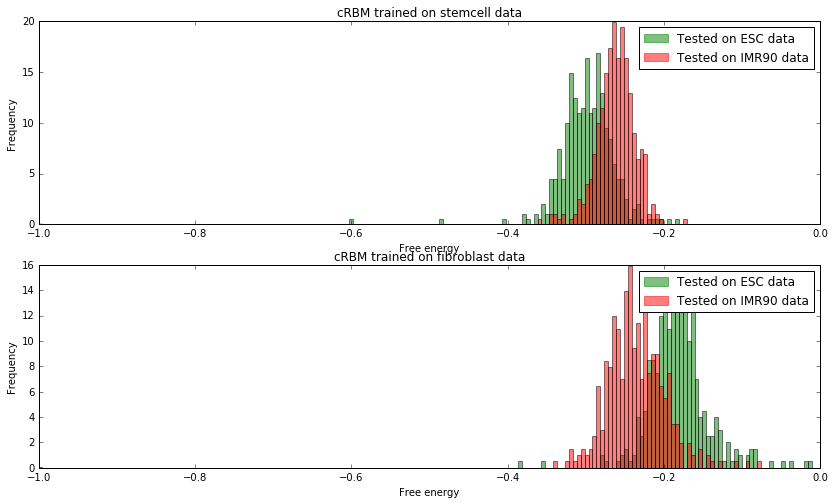

In [22]:
%matplotlib inline
import matplotlib.patches as mpatches

bins = np.linspace(-1, 0, 200)
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.hist(P11, bins, color='green', normed=True, alpha=0.5)
plt.hist(P12, bins, color='red', normed=True, alpha=0.5)
plt.title('cRBM trained on stemcell data')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1, 0))
green_patch = mpatches.Patch(color='green', label='Tested on ESC data', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Tested on IMR90 data', alpha=0.5)
plt.legend(handles=[green_patch, red_patch])

plt.subplot(2,1,2)
plt.hist(P21, bins, color='green', normed=True, alpha=0.5)
plt.hist(P22, bins, color='red', normed=True, alpha=0.5)
plt.title('cRBM trained on fibroblast data')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch = mpatches.Patch(color='green', label='Tested on ESC data', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Tested on IMR90 data', alpha=0.5)
plt.legend(handles=[green_patch, red_patch])
fig.savefig(modelDir_1 + '/discriminative_histograms.png', dpi=400)
fig.savefig(modelDir_2 + '/discriminative_histograms.png', dpi=400)

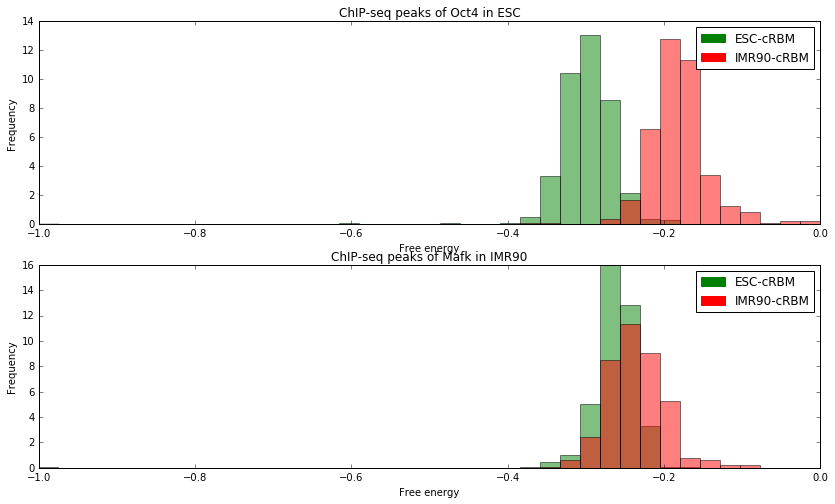

In [23]:
%matplotlib inline

bins = np.linspace(-1, 0, 40)
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.hist(P11, bins, color='green', normed=True, alpha=0.5)
plt.hist(P21, bins, color='red', normed=True, alpha=0.5)
plt.title('ChIP-seq peaks of Oct4 in ESC')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch2 = mpatches.Patch(color='green', label='ESC-cRBM')
red_patch2 = mpatches.Patch(color='red', label='IMR90-cRBM')
plt.legend(handles=[green_patch2, red_patch2])

plt.subplot(2,1,2)
plt.hist(P12, bins, color='green', normed=True, alpha=0.5)
plt.hist(P22, bins, color='red', normed=True, alpha=0.5)
plt.title('ChIP-seq peaks of Mafk in IMR90')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch = mpatches.Patch(color='green', label='ESC-cRBM')
red_patch = mpatches.Patch(color='red', label='IMR90-cRBM')
plt.legend(handles=[green_patch, red_patch])

# Calculating area under the curve and respective ROC plots
We want to find out how well we are predicting, using the standard measures of machine learning.
Thus, we want to calculate the accuracy and ROC curve as well as the AUC (area under the curve) value.

Done reading models...
(115,)
(115,)
(115,)
Done with sparsity constraint 0.1
(107,)
(107,)
(107,)
Done with sparsity constraint 0.5
(93,)
(93,)
(93,)
Done with sparsity constraint 1
(95,)
(95,)
(95,)
Done with sparsity constraint 5
(135,)
(135,)
(135,)
Done with sparsity constraint 10
(179,)
(179,)
(179,)
Done with sparsity constraint 50


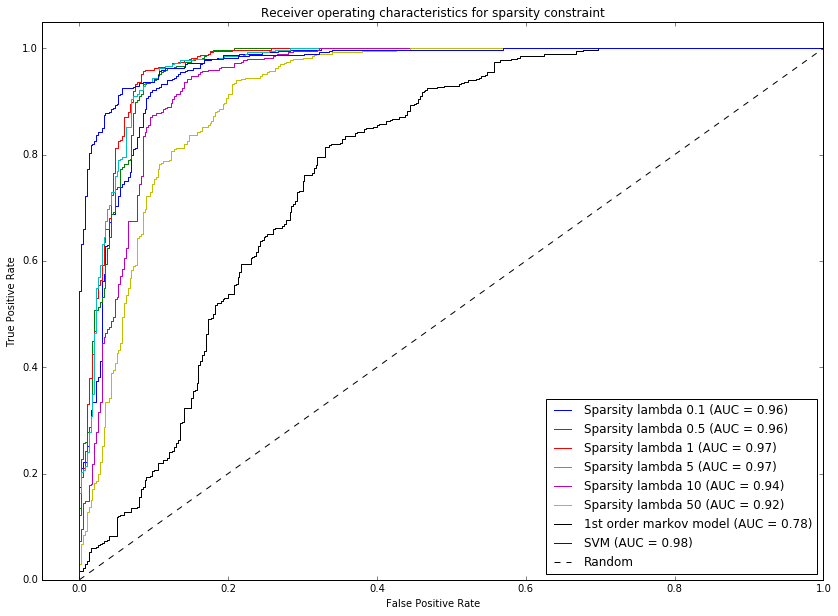

In [24]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

models_sc = []
models_fib = []
dir_names = [('Training_stemcells_sparsity_0.1', 'Training_fibroblast_sparsity_0.1'),
             ('Training_stemcells_sparsity_0.5', 'Training_fibroblast_sparsity_0.5'),
             ('Training_stemcells_sparsity_1', 'Training_fibroblast_sparsity_1'),
             ('Training_stemcells_sparsity_5', 'Training_fibroblast_sparsity_5'),
             ('Training_stemcells_sparsity_10', 'Training_fibroblast_sparsity_10'),
             ('Training_stemcells_sparsity_50', 'Training_fibroblast_sparsity_50')]

for dir_name1, dir_name2 in dir_names:
    # read in the models
    modelDir_1 = '../../training/sparsity_constraints/' + dir_name1
    stemcell_model = CRBM(file_name = modelDir_1 + '/model.pkl')

    modelDir_2 = '../../training/sparsity_constraints/' + dir_name2
    fibroblast_model = CRBM(file_name = modelDir_2 + '/model.pkl')
    
    models_sc.append(stemcell_model)
    models_fib.append(fibroblast_model)

print "Done reading models..."
fig = plt.figure(figsize=(14,10))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i in range(len(models_sc)):
    # calculate free energy for all data
    score_sc = getFreeEnergyPoints(models_sc[i], testset_all)
    score_fib = getFreeEnergyPoints(models_fib[i], testset_all)
    subtracted = score_fib - score_sc

    # get the scores and plot them
    y_true = np.concatenate( (np.ones(testset_size), np.zeros(testset_size)), axis=0 )
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=subtracted)
    roc_auc = auc(fpr, tpr)
    print thresholds.shape
    print tpr.shape
    print fpr.shape
    
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    # plot
    assert models_sc[i].hyper_params['sparsity'] == models_fib[i].hyper_params['sparsity']
    sparsity = models_sc[i].hyper_params['sparsity']
    plt.plot(fpr, tpr, label='Sparsity lambda ' + str(sparsity) + ' (AUC = %0.2f)' % roc_auc)
    
    print "Done with sparsity constraint " + str(sparsity)


# plot the markov model for comparision
y_true_mm = np.concatenate( (np.ones(testset_size), np.zeros(testset_size)), axis=0 )
fpr, tpr, thresholds = roc_curve(y_true=y_true_mm, y_score=(scores_sc - scores_fib))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='1st order markov model (AUC = %0.2f)' % roc_auc)

# plot the SVM model
fpr, tpr, thresholds = roc_curve(y_true=y_true_mm, y_score=scores_svm[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVM (AUC = %0.2f)' % roc_auc)

# plot the random chance diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random') # the diagonal

# set parameters for plotting
plt.ylim([0.0, 1.05])
plt.xlim([-0.05, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for sparsity constraint')
plt.legend(loc="lower right")
plt.show()
fig.savefig('ROC_for_sparsity.png', dpi=400)

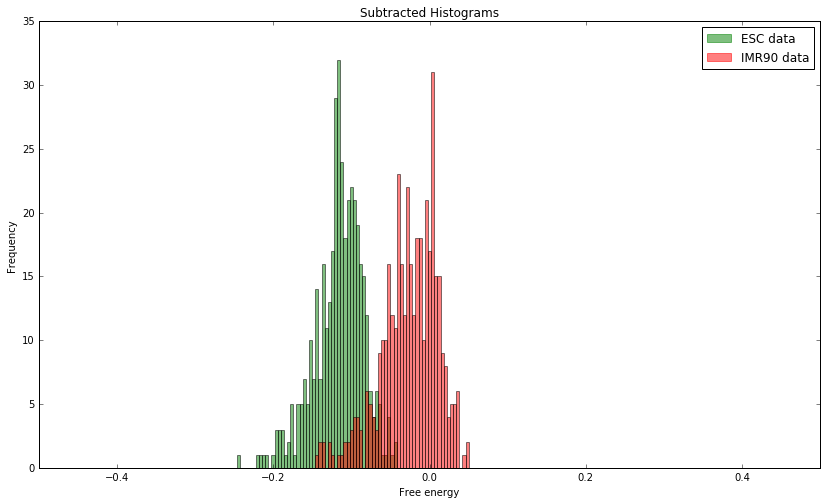

In [25]:
bins = np.linspace(-1, 1, 500)
fig = plt.figure(figsize=(14,8))
plt.hist(P11 - P21, bins, color='green', alpha=0.5)
plt.hist(P12 - P22, bins, color='red', alpha=0.5)
plt.title('Subtracted Histograms')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-.5,.5))
green_patch = mpatches.Patch(color='green', label='ESC data', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='IMR90 data', alpha=0.5)
plt.legend(handles=[green_patch, red_patch])
fig.savefig(modelDir_1 + '/histograms_subtracted.png', dpi=400)
fig.savefig(modelDir_2 + '/histograms_subtracted.png', dpi=400)

In [26]:
score_sc = getFreeEnergyPoints(stemcell_model, testset_all)
score_fib = getFreeEnergyPoints(fibroblast_model, testset_all)

(-0.5, 0.5)

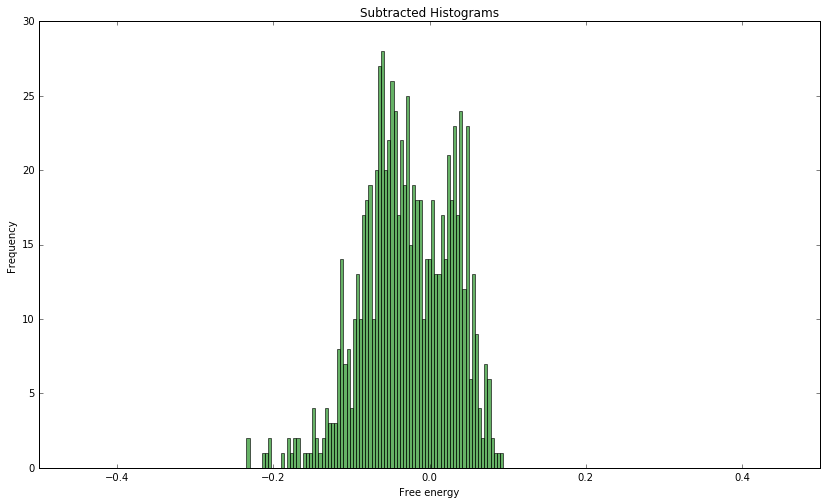

In [27]:
fig = plt.figure(figsize=(14,8))
bins = np.linspace(-1, 1, 500)
subtracted = score_sc - score_fib
plt.hist(subtracted[:3997], bins, color='green', alpha=0.6)
plt.hist(subtracted[3997:], bins, color='red', alpha=0.6)
plt.title('Subtracted Histograms')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-.5,.5))

(-0.5, 0.5)

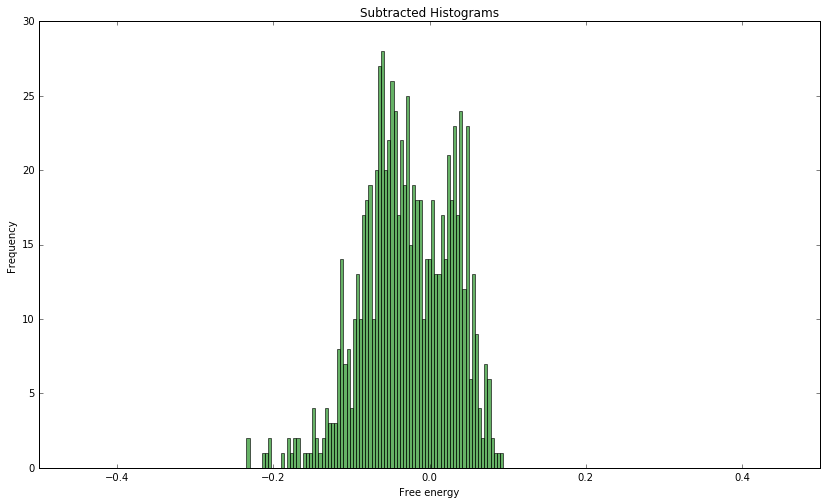

In [28]:
fig = plt.figure(figsize=(14,8))
plt.hist(score_sc - score_fib, bins, color='green', alpha=0.6)
plt.title('Subtracted Histograms')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-.5,.5))

0.91854375


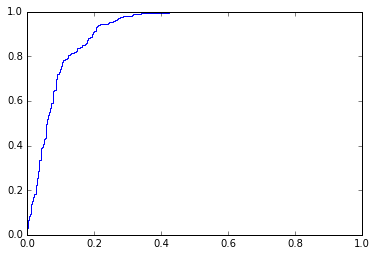

In [29]:
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=-subtracted)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Sparsity lambda ' + str(sparsity) + ' (AUC = %0.2f)' % roc_auc)
print roc_auc

[ 14.68  -3.39  -5.04   5.64  18.73   0.29  -4.54   5.27  -8.25   3.88]


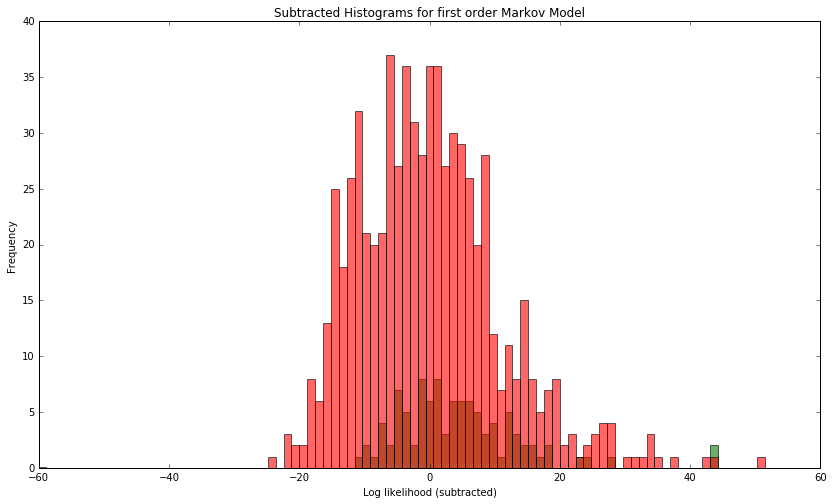

In [33]:

bins = np.linspace(-60, 60, 100)
fig = plt.figure(figsize=(14,8))
subtracted = scores_mm
print subtracted[:10]
plt.hist(subtracted[:100], bins, color='green', alpha=0.6)
plt.hist(subtracted[100:], bins, color='red', alpha=0.6)
plt.title('Subtracted Histograms for first order Markov Model')
plt.ylabel('Frequency')
plt.xlabel('Log likelihood (subtracted)')

0.77591875


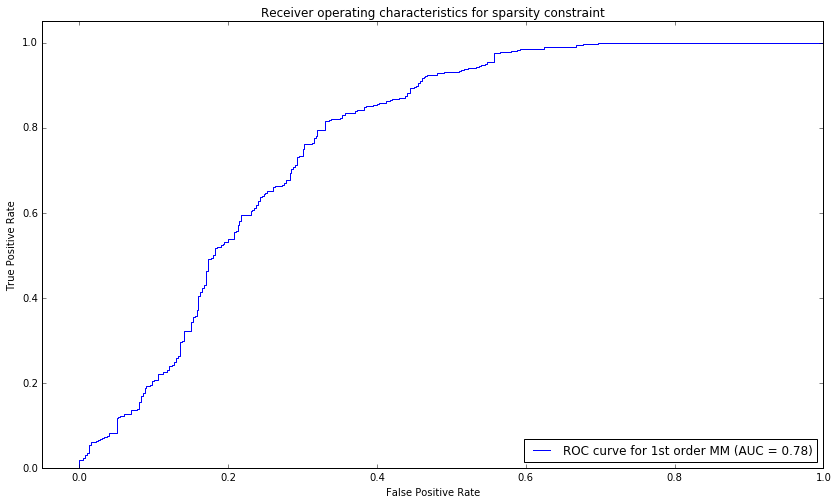

In [35]:
y_true = np.concatenate( (np.ones(testset_size), np.zeros(testset_size)), axis=0 )
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=subtracted)
roc_auc = auc(fpr, tpr)
print roc_auc
# plot

fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, label='ROC curve for 1st order MM (AUC = %0.2f)' % roc_auc)
plt.ylim([0.0, 1.05])
plt.xlim([-0.05, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for sparsity constraint')
plt.legend(loc="lower right")
#fig.savefig('ROC_for_sparsity.png', dpi=400)

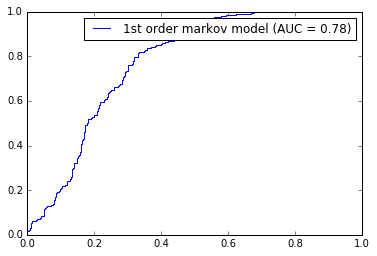

In [37]:
y_true = np.concatenate( (np.ones(testset_size), np.zeros(testset_size)), axis=0 )
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=(scores_sc - scores_fib))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='1st order markov model (AUC = %0.2f)' % roc_auc)
plt.legend()

In [38]:
import cPickle

assert scores_mm.shape == scores_svm[:,1].shape
print scores_mm.shape
print scores_svm[:,1].shape
with open('svm_mm_score_test400.pkl', 'w') as f:
    cPickle.dump( (scores_mm, scores_svm), f )

(800,)
(800,)


# Plot ROC from dumped file